In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

# Visualisation des données

### Visualisation table/description 

In [30]:
hmeq=pd.read_csv(r"C:\Users\chemm\Desktop\cours\MOSEF\Python\Exercice\Scoring\Projet_scoring\data\hmeq.csv")
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [31]:
description = hmeq.describe()
print("Statistiques descriptives :\n", description)

Statistiques descriptives :
                BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5960.000000   5960.000000    5442.000000    5848.000000  5445.000000   
mean      0.199497  18607.969799   73760.817200  101776.048741     8.922268   
std       0.399656  11207.480417   44457.609458   57385.775334     7.573982   
min       0.000000   1100.000000    2063.000000    8000.000000     0.000000   
25%       0.000000  11100.000000   46276.000000   66075.500000     3.000000   
50%       0.000000  16300.000000   65019.000000   89235.500000     7.000000   
75%       0.000000  23300.000000   91488.000000  119824.250000    13.000000   
max       1.000000  89900.000000  399550.000000  855909.000000    41.000000   

             DEROG       DELINQ        CLAGE         NINQ         CLNO  \
count  5252.000000  5380.000000  5652.000000  5450.000000  5738.000000   
mean      0.254570     0.449442   179.766275     1.186055    21.296096   
std       0.846047     1.127266    85

In [24]:
numerical_cols = hmeq.select_dtypes(include=['float64', 'int64']).columns

In [26]:
# Imputer les valeurs manquantes avec la médiane
hmeq_imputed = hmeq[numerical_cols].fillna(hmeq[numerical_cols].median())

# Appliquer Isolation Forest sur les données imputées
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers_pred = iso_forest.fit_predict(hmeq_imputed)

# Ajouter les prédictions d'outliers dans le DataFrame
hmeq['is_outlier'] = outliers_pred

# Filtrer les observations qui sont des outliers
outliers = hmeq[hmeq['is_outlier'] == -1]

# Afficher les outliers
outliers.head()


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,is_outlier
31,1,2800,50795.0,63100.0,HomeImp,Self,26.0,2.0,15.0,145.633333,3.0,45.0,NaN,-1
44,1,3000,NaN,14500.0,HomeImp,Other,3.0,0.0,0.0,9.300000,14.0,2.0,NaN,-1
59,1,3300,130518.0,164317.0,DebtCon,Other,9.0,0.0,6.0,192.289149,0.0,33.0,35.730559,-1
175,1,5000,NaN,37500.0,HomeImp,Other,NaN,0.0,3.0,107.133333,10.0,5.0,NaN,-1
178,1,5000,10171.0,26809.0,HomeImp,Office,13.0,3.0,6.0,228.300000,0.0,24.0,NaN,-1


In [34]:
from sklearn.ensemble import IsolationForest

# Créer un modèle d'Isolation Forest (si ce n'est pas déjà fait)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers_pred = iso_forest.fit_predict(hmeq[numerical_cols].dropna())

# Ajouter les prédictions d'outliers dans le DataFrame (1 = normal, -1 = outlier)
hmeq['is_outlier'] = outliers_pred

# Filtrer les observations qui sont des outliers (is_outlier = -1)
outliers = hmeq[hmeq['is_outlier'] == -1]

# Afficher les observations
print(outliers)

# Option pour afficher les 10 premiers outliers
outliers.head(10)


ValueError: Length of values (3515) does not match length of index (5960)

In [33]:
from sklearn.ensemble import IsolationForest

def count_outliers_isolation_forest(df, columns):
    # Créer un modèle d'isolation forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)  # contamination = proportion attendue d'outliers
    outliers = iso_forest.fit_predict(df[columns].dropna())

    # Compter les -1, qui indiquent les outliers
    num_outliers = np.sum(outliers == -1)
    return num_outliers

# Appliquer la méthode à toutes les colonnes numériques
num_outliers = count_outliers_isolation_forest(hmeq, numerical_cols)
print(f'Nombre total d\'outliers (Isolation Forest): {num_outliers}')


Nombre total d'outliers (Isolation Forest): 176


In [11]:
def count_outliers_percentile(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)

    # Compter les valeurs en dehors des bornes
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)

# Appliquer la méthode à chaque colonne
for col in numerical_cols:
    num_outliers = count_outliers_percentile(hmeq, col)
    print(f'Nombre d\'outliers dans {col} (Percentiles): {num_outliers}')


Nombre d'outliers dans BAD (Percentiles): 0
Nombre d'outliers dans LOAN (Percentiles): 120
Nombre d'outliers dans MORTDUE (Percentiles): 110
Nombre d'outliers dans VALUE (Percentiles): 118
Nombre d'outliers dans YOJ (Percentiles): 30
Nombre d'outliers dans DEROG (Percentiles): 49
Nombre d'outliers dans DELINQ (Percentiles): 52
Nombre d'outliers dans CLAGE (Percentiles): 114
Nombre d'outliers dans NINQ (Percentiles): 55
Nombre d'outliers dans CLNO (Percentiles): 57
Nombre d'outliers dans DEBTINC (Percentiles): 94


### Analyse des valeurs manquantes

In [4]:
missing_data_total = hmeq.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values Total')
missing_data_total['Percentage Missing Total'] = (missing_data_total['Missing Values Total'] / len(hmeq)) * 100

# Calculer les valeurs manquantes pour BAD = 1
hmeq_bad_1 = hmeq[hmeq['BAD'] == 1]
missing_data_bad_1 = hmeq_bad_1.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values BAD = 1')
missing_data_bad_1['Percentage Missing BAD = 1'] = (missing_data_bad_1['Missing Values BAD = 1'] / len(hmeq_bad_1)) * 100

# Calculer les valeurs manquantes pour BAD = 0
hmeq_bad_0 = hmeq[hmeq['BAD'] == 0]
missing_data_bad_0 = hmeq_bad_0.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values BAD = 0')
missing_data_bad_0['Percentage Missing BAD = 0'] = (missing_data_bad_0['Missing Values BAD = 0'] / len(hmeq_bad_0)) * 100

missing_data_combined = missing_data_total.merge(missing_data_bad_1, on='Variables').merge(missing_data_bad_0, on='Variables')

missing_data_combined = missing_data_combined.sort_values(by='Percentage Missing Total', ascending=False)
missing_data_combined

,Variables,Missing Values Total,Percentage Missing Total,Missing Values BAD = 1,Percentage Missing BAD = 1,Missing Values BAD = 0,Percentage Missing BAD = 0
12,DEBTINC,1267,21.258389,786,66.105971,481,10.081744
7,DEROG,708,11.879195,87,7.317073,621,13.016139
8,DELINQ,580,9.731544,72,6.055509,508,10.647663
2,MORTDUE,518,8.691275,106,8.915055,412,8.635506
6,YOJ,515,8.640940,65,5.466779,450,9.431985
10,NINQ,510,8.557047,75,6.307822,435,9.117585
9,CLAGE,308,5.167785,78,6.560135,230,4.820792
5,JOB,279,4.681208,23,1.934399,256,5.365751
4,REASON,252,4.228188,48,4.037006,204,4.275833
11,CLNO,222,3.724832,53,4.457527,169,3.542234


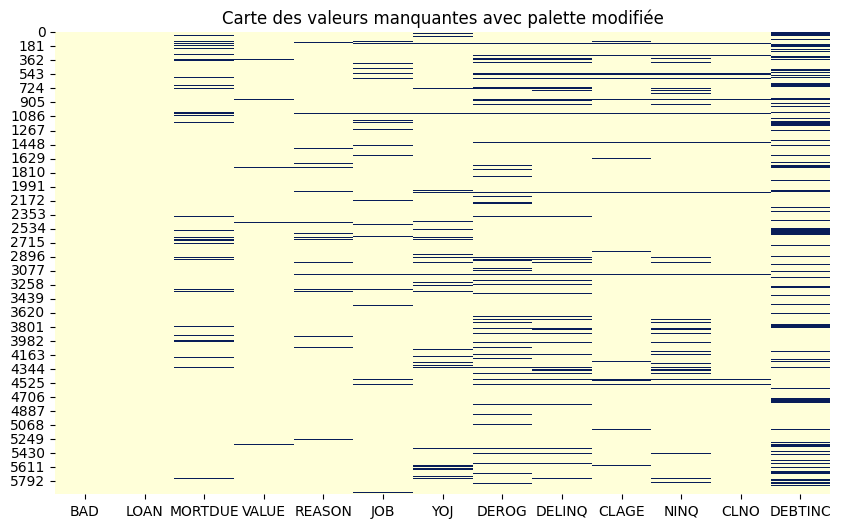

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(hmeq.isnull(), cbar=False, cmap='YlGnBu') 
plt.title("Carte des valeurs manquantes avec palette modifiée")
plt.show()

### Boxplot et densité


Skewness des variables :
 LOAN       2.023781
MORTDUE    1.814481
VALUE      3.053344
YOJ        0.988460
DEROG      5.320870
DELINQ     4.023150
CLAGE      1.343412
NINQ       2.621984
CLNO       0.775052
DEBTINC    2.852353
dtype: float64

Kurtosis des variables :
 LOAN        6.932590
MORTDUE     6.481866
VALUE      24.362805
YOJ         0.372072
DEROG      36.872763
DELINQ     23.565449
CLAGE       7.599549
NINQ        9.786507
CLNO        1.157673
DEBTINC    50.504042
dtype: float64


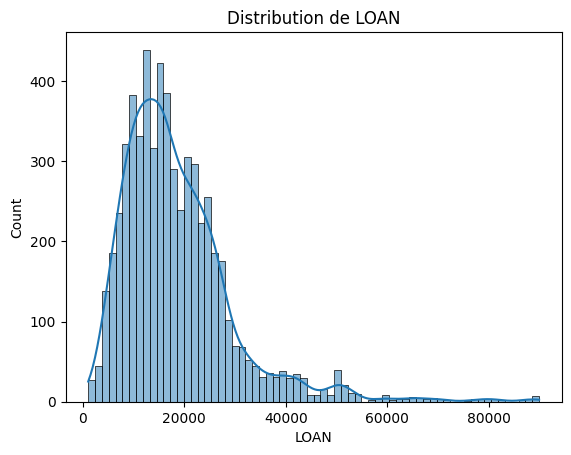

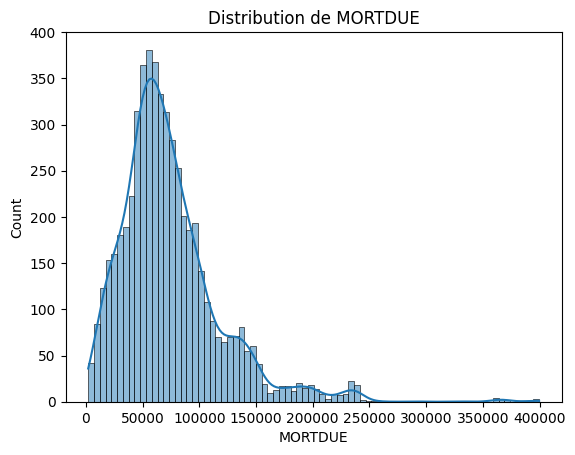

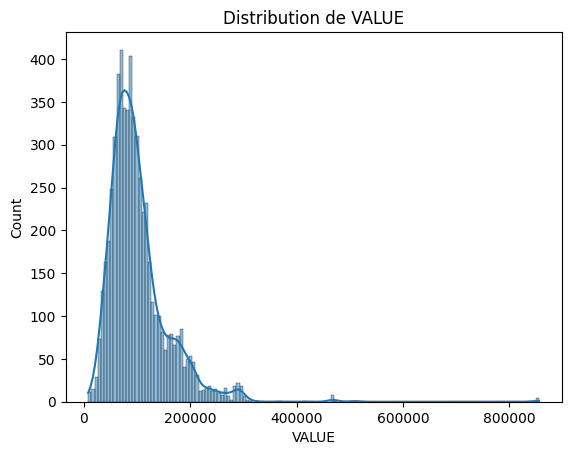

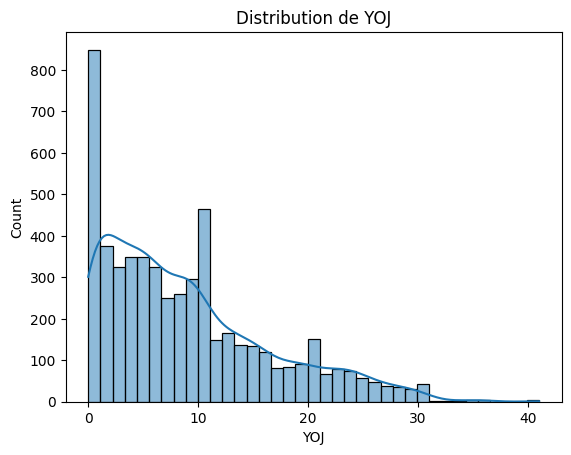

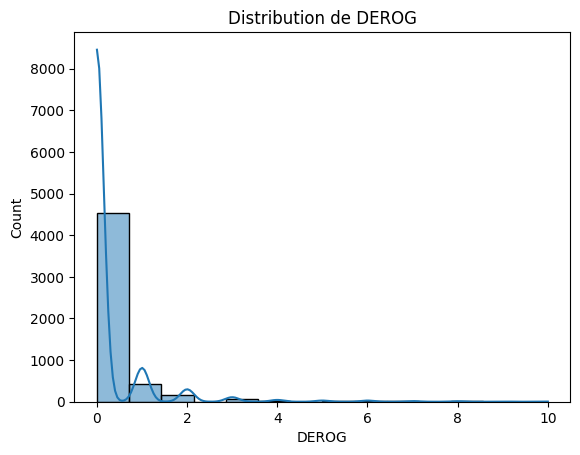

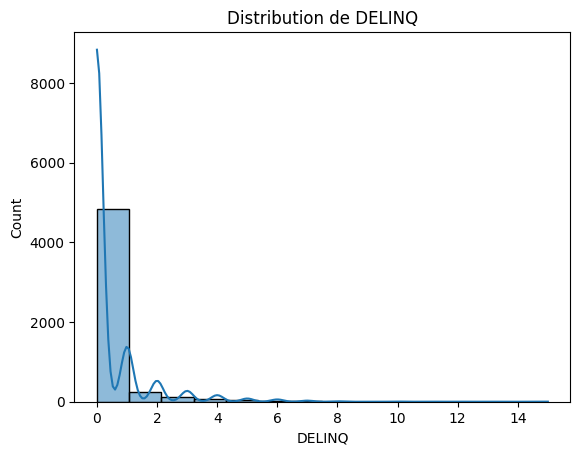

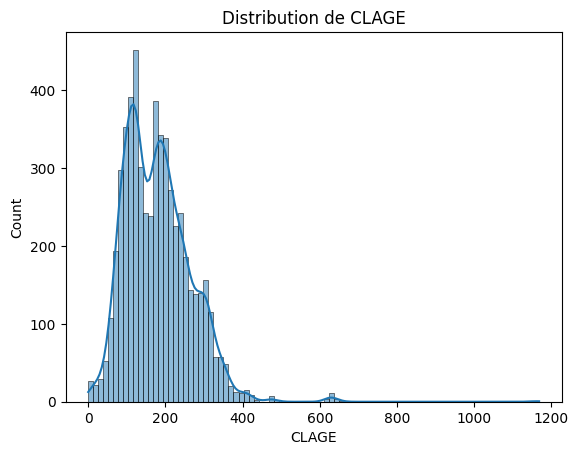

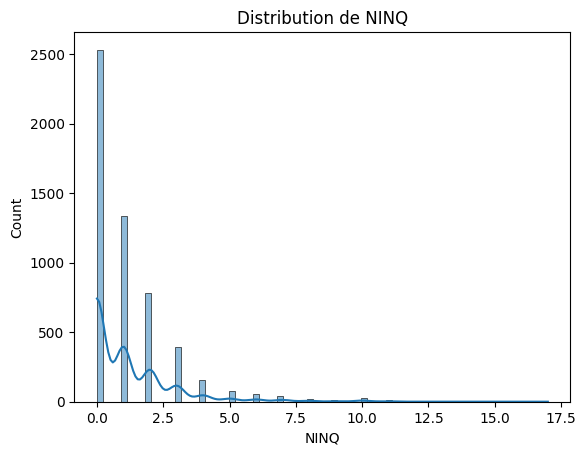

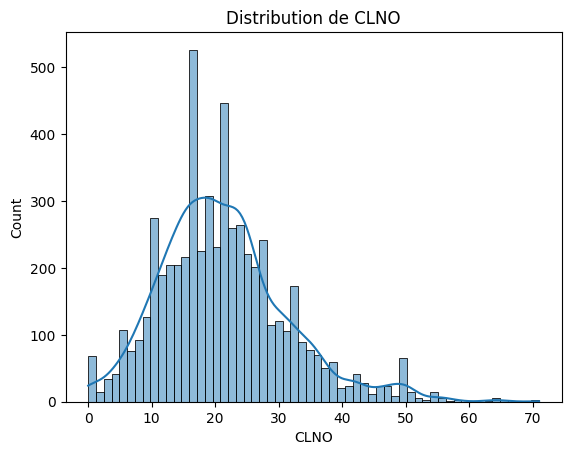

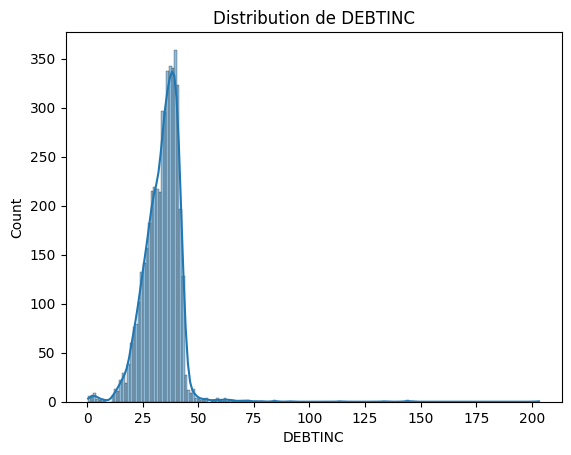

In [6]:
numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

skewness = hmeq[numeric_columns].skew()
kurtosis = hmeq[numeric_columns].kurtosis()
print("\nSkewness des variables :\n", skewness)
print("\nKurtosis des variables :\n", kurtosis)

for col in numeric_columns:
    plt.figure()
    sns.histplot(hmeq[col].dropna(), kde=True)
    plt.title(f'Distribution de {col}')
    plt.show()

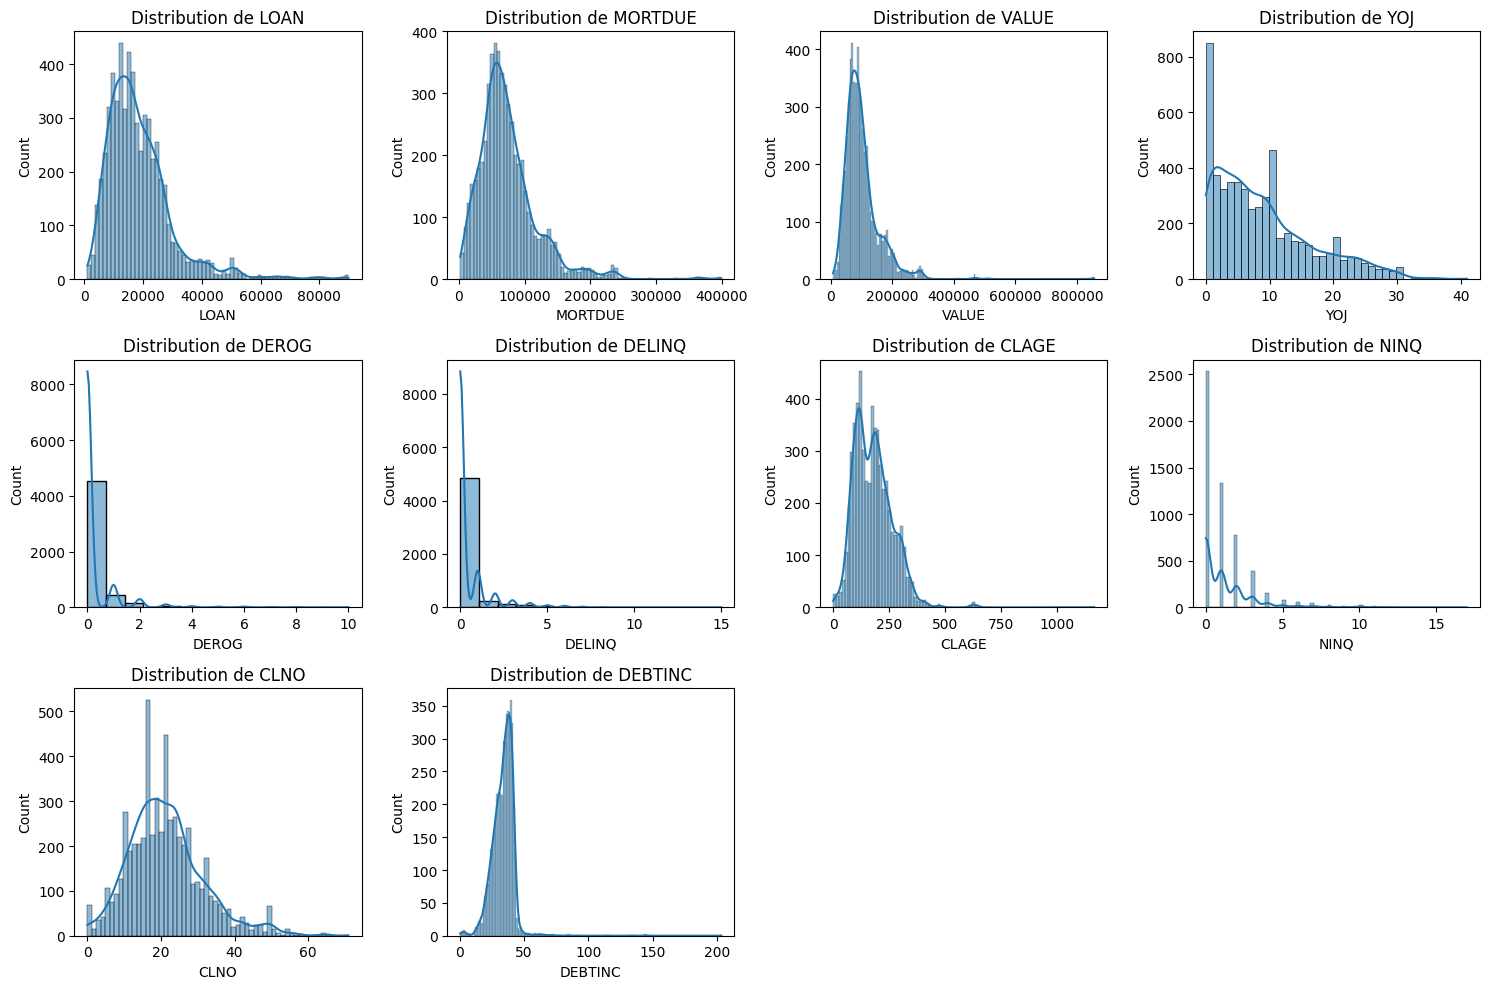

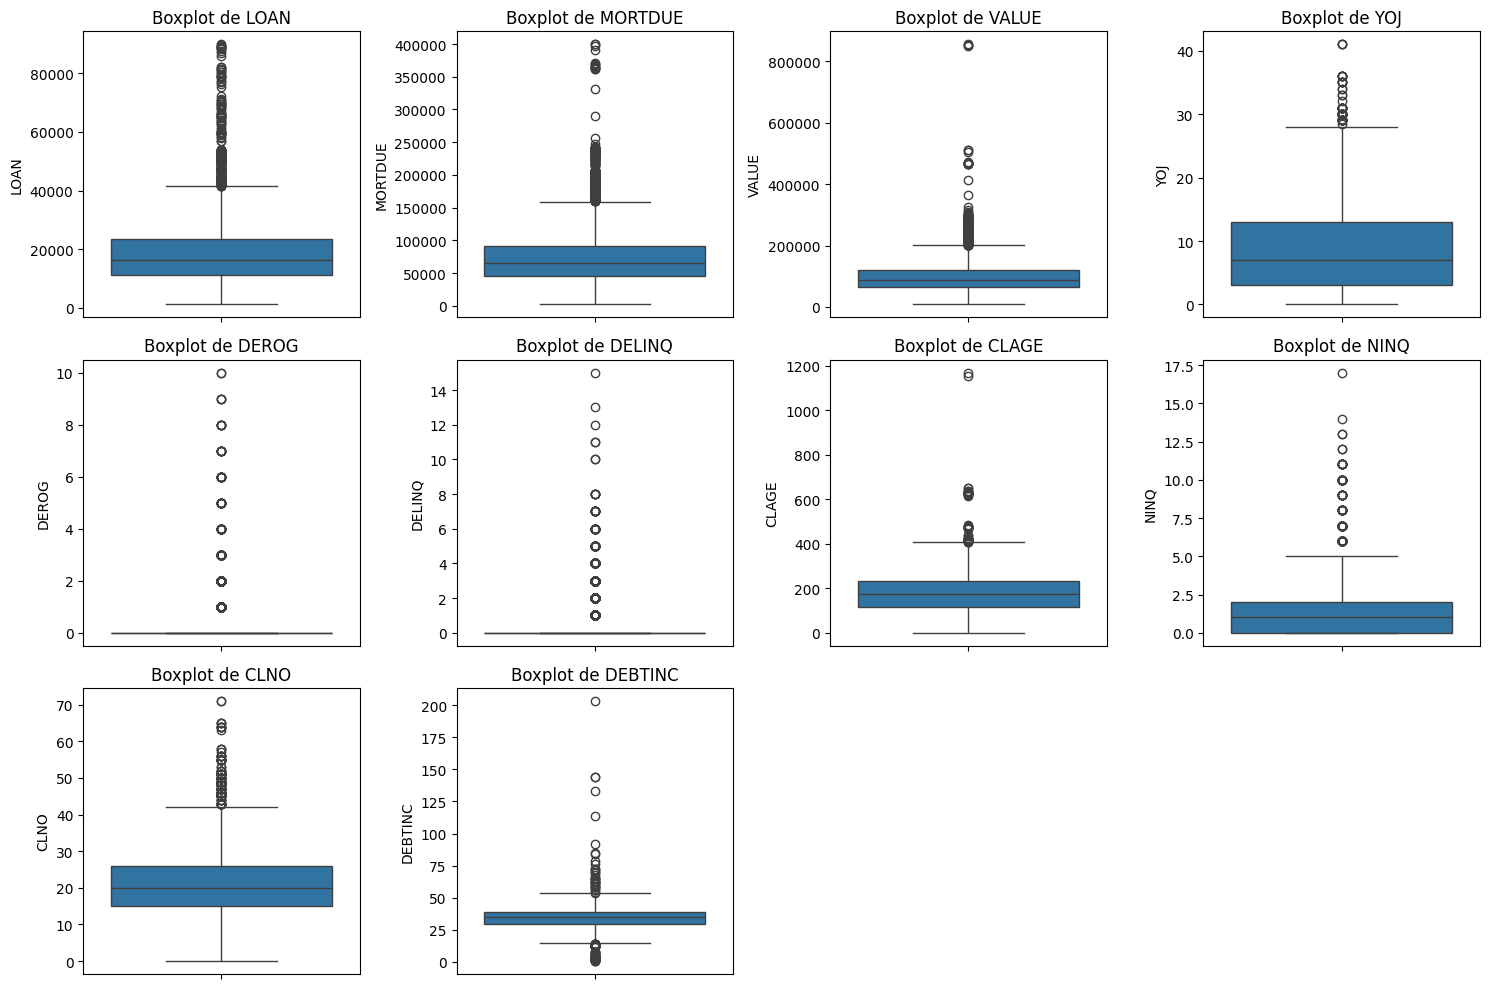

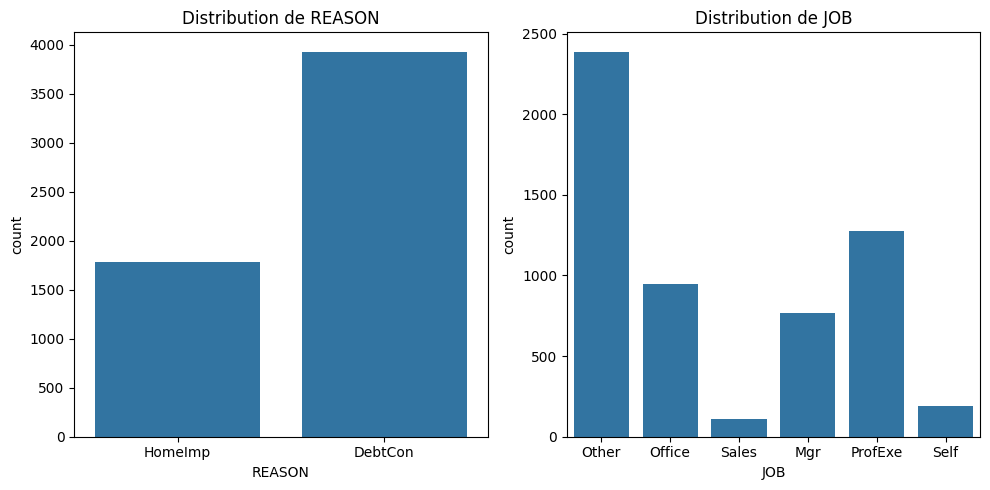

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
categorical_columns = ['REASON','JOB']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(hmeq[col].dropna(), kde=True)  # kde=True pour inclure la courbe de densité
    plt.title(f"Distribution de {col}")
plt.tight_layout()
plt.show()

# 2. Boxplot pour détecter les outliers dans les variables numériques
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(hmeq[col].dropna())
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

# Barplot pour 'REASON'
plt.subplot(1, 2, 1)
sns.countplot(x='REASON', data=hmeq)
plt.title("Distribution de REASON")

# Barplot pour 'JOB'
plt.subplot(1, 2, 2)
sns.countplot(x='JOB', data=hmeq)
plt.title("Distribution de JOB")

plt.tight_layout()
plt.show()


### Valeurs extreme

In [8]:
numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
for col in numeric_columns:
    upper_limit = hmeq[col].quantile(0.99)
    hmeq[col] = np.where(hmeq[col] > upper_limit, upper_limit, hmeq[col])
print("Statistiques descriptives après limitation des valeurs extrêmes :")
print(hmeq[numeric_columns].describe())

Statistiques descriptives après limitation des valeurs extrêmes :
               LOAN        MORTDUE          VALUE          YOJ        DEROG  \
count   5960.000000    5442.000000    5848.000000  5445.000000  5252.000000   
mean   18469.083893   73348.848172  100923.156505     8.900964     0.231721   
std    10540.219148   42349.225901   51730.977747     7.505444     0.685430   
min     1100.000000    2063.000000    8000.000000     0.000000     0.000000   
25%    11100.000000   46276.000000   66075.500000     3.000000     0.000000   
50%    16300.000000   65019.000000   89235.500000     7.000000     0.000000   
75%    23300.000000   91488.000000  119824.250000    13.000000     0.000000   
max    60869.000000  232230.410000  289962.800000    30.000000     4.000000   

            DELINQ        CLAGE         NINQ         CLNO      DEBTINC  
count  5380.000000  5652.000000  5450.000000  5738.000000  4693.000000  
mean      0.428067   178.572904     1.167349    21.237191    33.560672  
std

### f

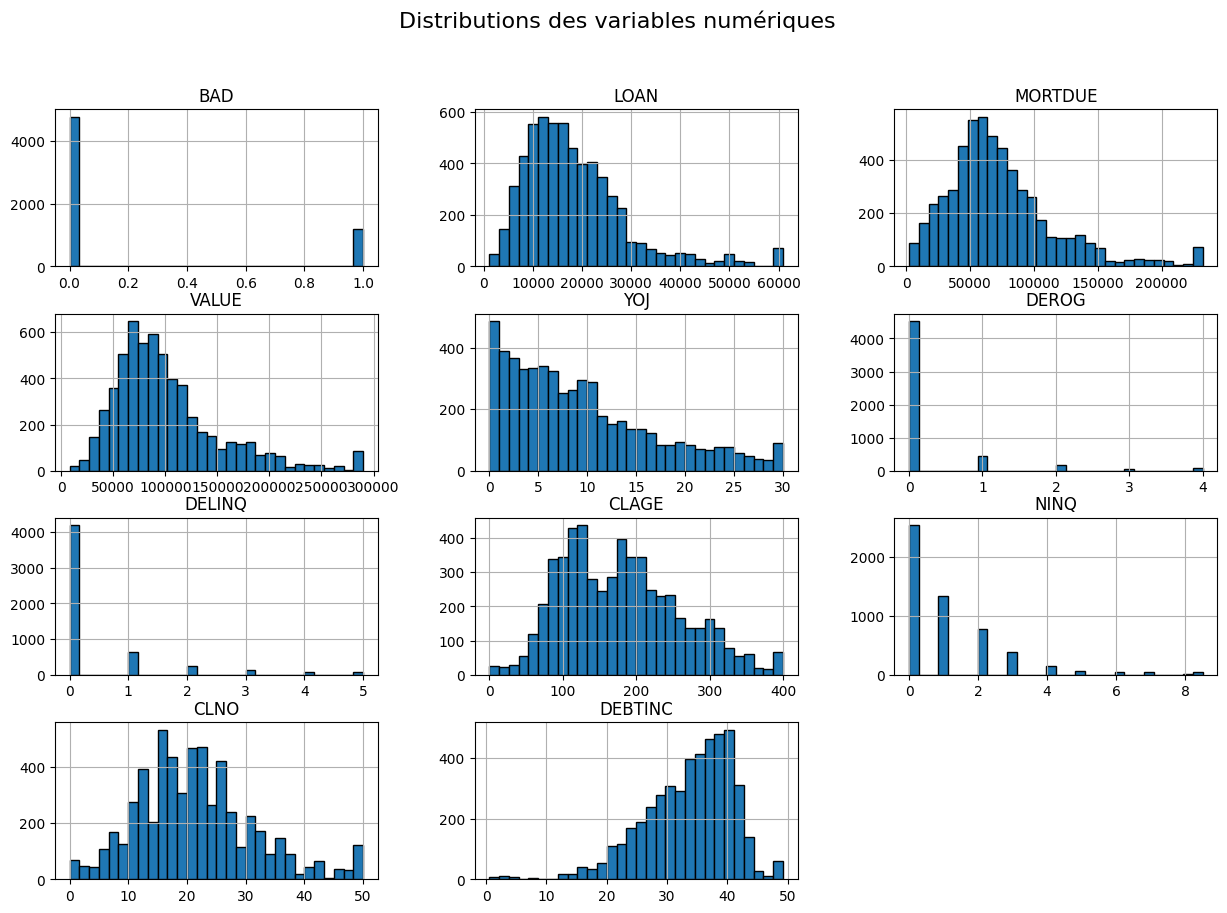

In [9]:
# Variables numériques - Distributions (histogrammes)
numerical_columns = hmeq.select_dtypes(include=['float64', 'int64']).columns
hmeq[numerical_columns].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle("Distributions des variables numériques", size=16)
plt.show()


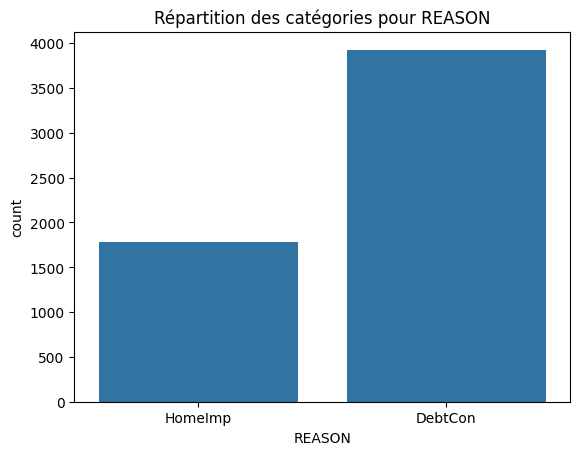

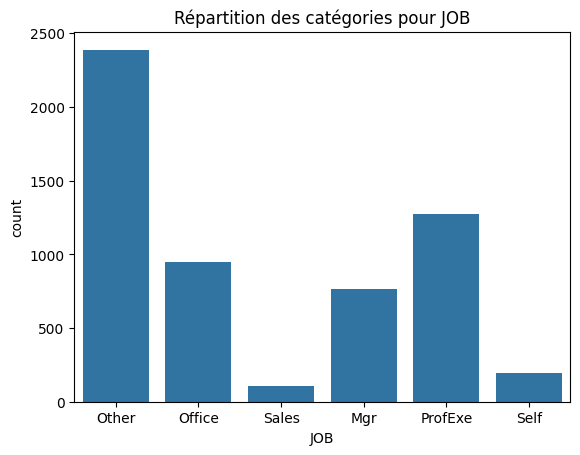

In [10]:
# Variables catégorielles - Bar plots pour la répartition des catégories
for col in categorical_columns:
    sns.countplot(x=col, data=hmeq)
    plt.title(f"Répartition des catégories pour {col}")
    plt.show()


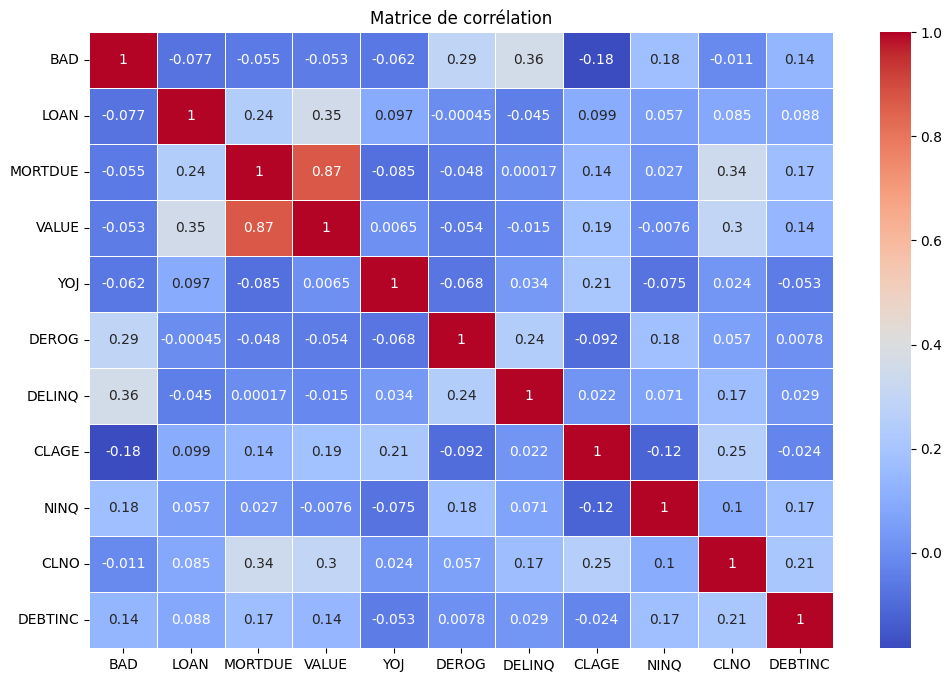

In [11]:
# Heatmap de corrélation pour les variables numériques
corr_matrix = hmeq[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()


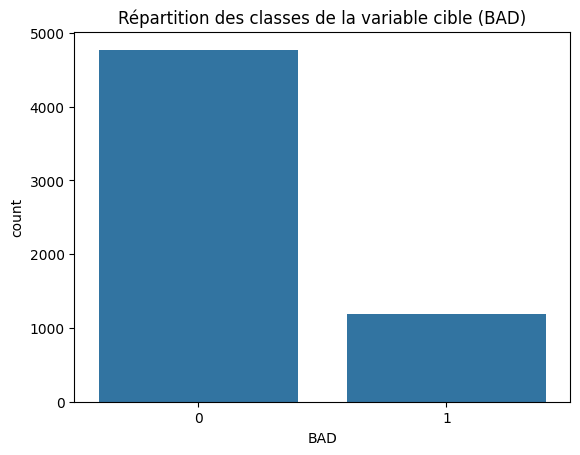

In [12]:
# Proportion des classes dans la variable 'BAD'
class_balance = hmeq['BAD'].value_counts(normalize=True)

# Visualisation de la répartition des classes
sns.countplot(x='BAD', data=hmeq)
plt.title('Répartition des classes de la variable cible (BAD)')
plt.show()


In [13]:
# # Exemple d'interaction entre LOAN et VALUE avec la variable cible BAD
# sns.scatterplot(x='LOAN', y='VALUE', hue='BAD', data=hmeq)
# plt.title('Relation entre LOAN et VALUE selon BAD')
# plt.show()


In [14]:
# Vérification de la multicolinéarité avec le VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Supprimer la colonne BAD et les valeurs manquantes pour le calcul du VIF
X = hmeq[numerical_columns].drop(columns=['BAD'], errors='ignore').dropna()

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data


,Variable,VIF
0,LOAN,5.423711
1,MORTDUE,17.141168
2,VALUE,22.403677
3,YOJ,2.652687
4,DEROG,1.158113
5,DELINQ,1.196332
6,CLAGE,7.203873
7,NINQ,1.602995
8,CLNO,8.065763
9,DEBTINC,11.331008


Les variables comme LOAN, MORTDUE, VALUE, DEBTINC, CLNO présentent des distributions asymétriques à droite, ce qui peut signifier la présence de valeurs extrêmes ou d'outliers

Les variables DEROG, DELINQ, et NINQ ont des distributions avec des valeurs nulles (0) prédominantes, indiquant que la majorité des individus dans ces groupes n'ont pas de défauts majeurs ou de delinquances dans leur historique de crédit.

Les variables CLAGE et YOJ (ancienneté des lignes de crédit et expérience professionnelle) montrent des distributions légèrement asymétriques, mais relativement bien réparties.

La variable REASON présente une majorité de cas pour DebtCon (consolidation de dettes), ce qui signifie que beaucoup de prêts sont contractés pour regrouper des dettes.

La variable JOB montre que la plupart des individus sont dans la catégorie Other, suivie de ProfExe et Mgr, ce qui pourrait indiquer un manque de granularité ou de diversité dans les catégories d'emploi.

Corrélations fortes entre certaines variables :
VALUE et MORTDUE : corrélation très élevée (0.88), ce qui est logique, car la valeur du bien est souvent fortement liée au montant restant à rembourser sur le prêt.

BAD présente une corrélation modérée avec DELINQ (0.35) et DEROG (0.28), ce qui signifie que ces variables jouent un rôle important dans la prédiction des défauts de paiement.

La classe 0 (non-défaillant) est largement dominante (~80%) par rapport à la classe 1 (défaillant, ~20%). Ce déséquilibre peut poser un problème dans la modélisation, car les modèles de machine learning auront tendance à prédire plus souvent la classe majoritaire.

Les variables MORTDUE, VALUE, et CLNO ont des VIF élevés, ce qui indique une multicolinéarité. La multicolinéarité peut affecter les performances de certains modèles, notamment la régression linéaire et logistique.

MORTDUE (17.25) et VALUE (22.03) sont fortement corrélées, comme vu dans la matrice de corrélation, et il pourrait être nécessaire de supprimer l'une des deux variables pour réduire la colinéarité.

CLNO (7.52) et DEBTINC (9.65) ont également des VIF élevés, ce qui mérite de l'attention.

Gérer la multicolinéarité :

MORTDUE et VALUE sont fortement corrélées. Il faudra choisir l'une des deux pour la conserver dans le modèle afin de réduire la multicolinéarité.
Les autres variables ayant des VIF élevés peuvent être conservées après transformation (comme log-transform) ou réduction de leur importance si elles ne contribuent pas fortement à la prédiction.
Transformer les variables asymétriques :

Les variables fortement asymétriques, comme LOAN, MORTDUE, DEBTINC, pourraient bénéficier d'une transformation logarithmique ou de la technique de Winsorisation pour réduire l'impact des outliers et stabiliser la variance.
Gérer le déséquilibre des classes :

Le déséquilibre des classes dans BAD (20% de défaillants) suggère l'utilisation de techniques de gestion des classes déséquilibrées comme :
SMOTE (Synthetic Minority Over-sampling Technique) pour générer artificiellement des échantillons de la classe minoritaire.
Sous-échantillonnage de la classe majoritaire ou suréchantillonnage de la classe minoritaire.
Création de nouvelles variables :

Envisager de créer de nouvelles variables pour capturer des interactions importantes entre les variables comme LOAN/CLAGE (montant du prêt et ancienneté des lignes de crédit) ou DEBTINC/CLAGE (ratio dette/revenu et ancienneté).
Imputation des valeurs manquantes :

Assurer une imputation correcte des valeurs manquantes dans les variables numériques et catégorielles avant toute modélisation.
Pour les variables numériques, utiliser la médiane ou une imputation basée sur des modèles pour éviter de biaiser les résultats.
Exploration de modèles robustes :

Envisager d'essayer des modèles moins sensibles aux multicolinéarités, tels que Random Forest ou XGBoost, qui sont moins impactés par les relations linéaires fortes entre les variables.

# Traitement de données

## Outliers

In [15]:
numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
for col in numeric_columns:
    upper_limit = hmeq[col].quantile(0.99)
    hmeq[col] = np.where(hmeq[col] > upper_limit, upper_limit, hmeq[col])
print("Statistiques descriptives après limitation des valeurs extrêmes :")
print(hmeq[numeric_columns].describe())

Statistiques descriptives après limitation des valeurs extrêmes :
               LOAN        MORTDUE          VALUE          YOJ        DEROG  \
count   5960.000000    5442.000000    5848.000000  5445.000000  5252.000000   
mean   18466.892181   73348.361660  100923.005716     8.900964     0.231721   
std    10531.419855   42347.400555   51730.426646     7.505444     0.685430   
min     1100.000000    2063.000000    8000.000000     0.000000     0.000000   
25%    11100.000000   46276.000000   66075.500000     3.000000     0.000000   
50%    16300.000000   65019.000000   89235.500000     7.000000     0.000000   
75%    23300.000000   91488.000000  119824.250000    13.000000     0.000000   
max    60651.290000  232182.271900  289947.854000    30.000000     4.000000   

            DELINQ        CLAGE         NINQ         CLNO      DEBTINC  
count  5380.000000  5652.000000  5450.000000  5738.000000  4693.000000  
mean      0.428067   178.571931     1.164827    21.237191    33.560544  
std

## Imputation

Accuracy (précision globale) : La proportion de prédictions correctes.

Précision (precision) : La proportion de prédictions positives correctes sur le total des prédictions positives.

Rappel (recall) : La proportion de vraies positives trouvées par rapport au total des vrais positifs (aussi appelée sensibilité).

F1-score : La moyenne harmonique entre précision et rappel.

AUC (Area Under the Curve) : L'aire sous la courbe ROC (Receiver Operating Characteristic), qui permet d'évaluer le compromis entre rappel et précision sur différentes valeurs de seuil.

Matrice de confusion : Une représentation graphique du nombre de vraies positives, vraies négatives, fausses positives, et fausses négatives.

### traitement imputation

#### Imputation test 

#### simple

Methode simple
Accuracy: 0.8177
Precision: 0.7039
Recall: 0.3158
F1-Score: 0.4360
AUC: 0.7922
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1389
           1       0.70      0.32      0.44       399

    accuracy                           0.82      1788
   macro avg       0.77      0.64      0.66      1788
weighted avg       0.80      0.82      0.79      1788



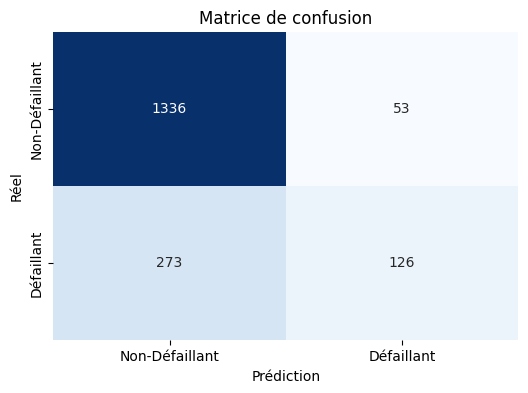

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Imputation des variables catégorielles sans inplace
hmeq['REASON'] = hmeq['REASON'].fillna(hmeq['REASON'].mode()[0])
hmeq['JOB'] = hmeq['JOB'].fillna(hmeq['JOB'].mode()[0])

# 2. Encodage des variables catégorielles avec One-Hot Encoding
hmeq_simple = pd.get_dummies(hmeq, columns=['REASON', 'JOB'], drop_first=True)

# 3. Imputation simple des variables numériques
numeric_columns = ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
hmeq_simple[numeric_columns] = hmeq_simple[numeric_columns].apply(lambda col: col.fillna(col.median()))

# 4. Séparation des données
X = hmeq_simple.drop(columns=['BAD'])
y = hmeq_simple['BAD']

# 5. Standardisation des données pour améliorer la convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 7. Entraînement du modèle de régression logistique avec augmentation des itérations
logreg = LogisticRegression(max_iter=2000)  # Augmenter max_iter pour assurer la convergence
logreg.fit(X_train, y_train)

# 8. Prédictions et évaluation des métriques
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Methode simple")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(classification_report(y_test, y_pred))

# 9. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Défaillant', 'Défaillant'], yticklabels=['Non-Défaillant', 'Défaillant'])
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()


#### 2. Imputation avec groupby sur BAD, incluant REASON et JOB

C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Methode par groupby
Accuracy: 0.7768
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC: 0.5713
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1389
           1       0.00      0.00      0.00       399

    accuracy                           0.78      1788
   macro avg       0.39      0.50      0.44      1788
weighted avg       0.60      0.78      0.68      1788



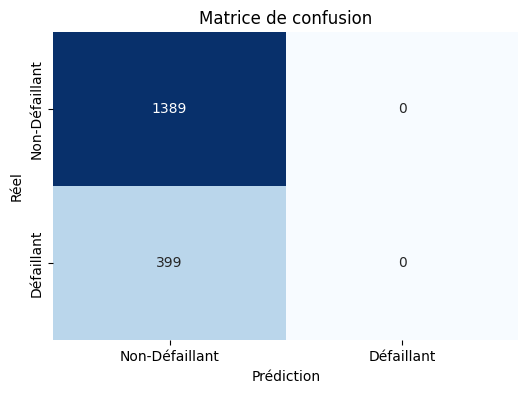

In [32]:
# 1. Imputation des variables catégorielles avec le mode (groupby sur BAD)
hmeq['REASON'] = hmeq.groupby('BAD')['REASON'].apply(lambda x: x.fillna(x.mode()[0])).reset_index(drop=True)
hmeq['JOB'] = hmeq.groupby('BAD')['JOB'].apply(lambda x: x.fillna(x.mode()[0])).reset_index(drop=True)

# 2. Encodage des variables catégorielles avec One-Hot Encoding
hmeq_groupby = pd.get_dummies(hmeq, columns=['REASON', 'JOB'], drop_first=True)

# 3. Imputation groupée par BAD pour les variables numériques
numeric_columns = ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
for col in numeric_columns:
    hmeq_groupby[col] = hmeq_groupby.groupby('BAD')[col].apply(lambda x: x.fillna(x.median())).reset_index(drop=True)

# 4. Séparation des données
X = hmeq_groupby.drop(columns=['BAD'])
y = hmeq_groupby['BAD']

# 5. Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 7. Entraînement du modèle de régression logistique avec augmentation des itérations
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)

# 8. Prédictions et évaluation des métriques
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Methode par groupby")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(classification_report(y_test, y_pred))

# 9. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Défaillant', 'Défaillant'], yticklabels=['Non-Défaillant', 'Défaillant'])
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()


#### 3. Imputation avec KNN, incluant REASON et JOB

C:\Users\chemm\AppData\Local\Temp\ipykernel_47980\1162102075.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hmeq['REASON'].fillna(hmeq['REASON'].mode()[0], inplace=True)
C:\Users\chemm\AppData\Local\Temp\ipykernel_47980\1162102075.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

Accuracy: 0.8031
Precision: 0.6577
Recall: 0.2456
F1-Score: 0.3577
AUC: 0.7433
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1389
           1       0.66      0.25      0.36       399

    accuracy                           0.80      1788
   macro avg       0.74      0.60      0.62      1788
weighted avg       0.78      0.80      0.77      1788



C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


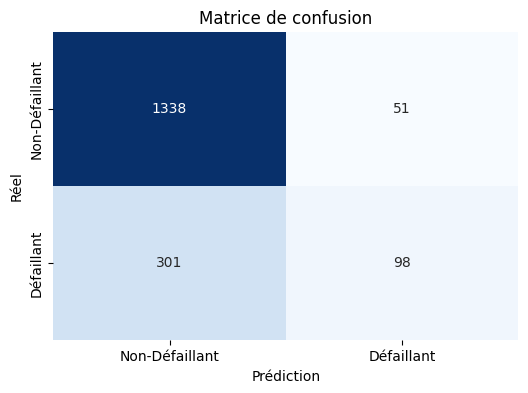

In [18]:
from sklearn.impute import KNNImputer

# 1. Imputation des variables catégorielles avec le mode
hmeq['REASON'].fillna(hmeq['REASON'].mode()[0], inplace=True)
hmeq['JOB'].fillna(hmeq['JOB'].mode()[0], inplace=True)

# 2. Encodage des variables catégorielles avec One-Hot Encoding
hmeq_knn = pd.get_dummies(hmeq, columns=['REASON', 'JOB'], drop_first=True)

# 3. Imputation avec KNN pour les variables numériques
numeric_columns = ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
knn_imputer = KNNImputer(n_neighbors=5)
hmeq_knn[numeric_columns] = knn_imputer.fit_transform(hmeq_knn[numeric_columns])

# 4. Séparation des données
X = hmeq_knn.drop(columns=['BAD'])
y = hmeq_knn['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Entraînement du modèle de régression logistique
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# 6. Prédictions et évaluation des métriques
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(classification_report(y_test, y_pred))

# 7. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Défaillant', 'Défaillant'], yticklabels=['Non-Défaillant', 'Défaillant'])
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()


Accuracy: 0.7718
Precision: 0.4893
Recall: 0.5138
F1-Score: 0.5012
AUC: 0.7522
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1389
           1       0.49      0.51      0.50       399

    accuracy                           0.77      1788
   macro avg       0.67      0.68      0.68      1788
weighted avg       0.78      0.77      0.77      1788



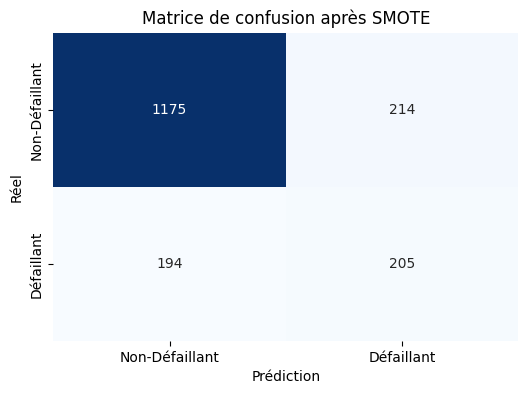

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Imputation des variables catégorielles
hmeq['REASON'] = hmeq['REASON'].fillna(hmeq['REASON'].mode()[0])
hmeq['JOB'] = hmeq['JOB'].fillna(hmeq['JOB'].mode()[0])

# 2. Encodage des variables catégorielles avec One-Hot Encoding
hmeq_smote = pd.get_dummies(hmeq, columns=['REASON', 'JOB'], drop_first=True)

# 3. Imputation des variables numériques avec la médiane
numeric_columns = ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
hmeq_smote[numeric_columns] = hmeq_smote[numeric_columns].apply(lambda col: col.fillna(col.median()))

# 4. Séparation des données
X = hmeq_smote.drop(columns=['BAD'])
y = hmeq_smote['BAD']

# 5. Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6. Application de SMOTE sur les données d'entraînement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 7. Standardisation des données
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# 8. Entraînement du modèle de régression logistique après SMOTE
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_smote_scaled, y_train_smote)

# 9. Prédictions et évaluation des métriques
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(classification_report(y_test, y_pred))

# 10. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Défaillant', 'Défaillant'], yticklabels=['Non-Défaillant', 'Défaillant'])
plt.title("Matrice de confusion après SMOTE")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()


#### hey

#### Imputation actuelle

In [20]:
# Imputation des valeurs manquantes pour les variables numériques avec la médiane
numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
hmeq[numeric_columns] = hmeq[numeric_columns].fillna(hmeq[numeric_columns].median())

# Imputation des valeurs manquantes pour les variables catégorielles avec le mode
categorical_columns = ['REASON', 'JOB']
hmeq[categorical_columns] = hmeq[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))


In [21]:
MissingData = hmeq.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values')
MissingData['Percentage Missing'] = (MissingData['Missing Values'] / len(hmeq)) * 100
MissingData = MissingData.sort_values(by='Percentage Missing', ascending=False)
MissingData

,Variables,Missing Values,Percentage Missing
0,BAD,0,0.0
1,LOAN,0,0.0
2,MORTDUE,0,0.0
3,VALUE,0,0.0
4,REASON,0,0.0
5,JOB,0,0.0
6,YOJ,0,0.0
7,DEROG,0,0.0
8,DELINQ,0,0.0
9,CLAGE,0,0.0


#### Encoding des varaible categorielle

In [22]:
hmeq_encoded = pd.get_dummies(hmeq, columns=['REASON', 'JOB'], drop_first=True)

## VIF

In [23]:
hmeq_encoded['LOAN_TO_VALUE'] = hmeq_encoded['LOAN'] / hmeq_encoded['VALUE']
hmeq_encoded['DEROG_DELINQ_INTERACTION'] = hmeq_encoded['DEROG'] * hmeq_encoded['DELINQ']
hmeq_encoded['DEBT_TO_INCOME'] = hmeq_encoded['DEBTINC'] / hmeq_encoded['LOAN']

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Séparation des données explicatives (X) et de la cible (y)
X = hmeq_encoded.drop(columns=['BAD'])
y = hmeq_encoded['BAD']

# Normalisation des variables avec StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# Split des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Régression logistique avec régularisation ElasticNet
elasticnet = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, l1_ratio=0.5)  
elasticnet.fit(X_train, y_train)

# Sélection des variables
model = SelectFromModel(elasticnet, prefit=True)
X_selected = model.transform(X_scaled)

# Affichage des variables sélectionnées
selected_features = X.columns[model.get_support()]
print("Variables sélectionnées avec ElasticNet :", selected_features)


Variables sélectionnées avec ElasticNet : Index(['MORTDUE', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'DEBTINC',
       'DEBT_TO_INCOME'],
      dtype='object')


## selection

## Standardisation ou normalisation des variables numériques

In [26]:
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Log transformation pour certaines variables asymétriques
hmeq['LOG_LOAN'] = np.log1p(hmeq['LOAN'])  # log1p pour gérer les valeurs nulles
hmeq['LOG_MORTDUE'] = np.log1p(hmeq['MORTDUE'])
hmeq['LOG_VALUE'] = np.log1p(hmeq['VALUE'])
hmeq['LOG_DEBTINC'] = np.log1p(hmeq['DEBTINC'])

# 2. Binarisation pour les variables très asymétriques
hmeq['DEROG_BIN'] = (hmeq['DEROG'] >= 1).astype(int)
hmeq['DELINQ_BIN'] = (hmeq['DELINQ'] >= 1).astype(int)
hmeq['NINQ_BIN'] = (hmeq['NINQ'] >= 1).astype(int)

# 3. Standardisation des variables normales
variables_to_scale = ['LOG_LOAN', 'LOG_MORTDUE', 'LOG_VALUE', 'CLAGE', 'CLNO', 'YOJ']
scaler = StandardScaler()
hmeq[variables_to_scale] = scaler.fit_transform(hmeq[variables_to_scale])

# 4. Imputation des valeurs manquantes
hmeq.fillna(hmeq.median(), inplace=True)

# 5. Encodage des variables catégorielles
hmeq = pd.get_dummies(hmeq, columns=['REASON', 'JOB'], drop_first=True)

# 6. Séparation des données
X = hmeq.drop(columns=['BAD'])
y = hmeq['BAD']

# 7. Séparation en ensemble d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 8. Entraînement d'un modèle de Random Forest comme exemple
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 9. Prédictions et évaluation
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


TypeError: Cannot convert [['Office' 'Mgr' 'Office' ... 'Other' 'Self' 'Self']] to numeric